In [2]:
# Install necessary libraries if not already installed
# !pip install torch matplotlib torchsde
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

import math
import sys
import os

# Add the library path to sys.path
library_path = '../'
if library_path not in sys.path:
    sys.path.append(library_path)
import time
import torch
import torchsde
import numpy as np
import matplotlib.pyplot as plt
from torchcfm.models.models import MLP
from torchcfm.utils import sample_checkerboard, sample_8gaussians, plot_trajectories_m, plot_trajectories
from torchcfm.conditional_flow_matching import ExactOptimalTransportConditionalFlowMatcher

# Enable inline plotting
%matplotlib inline
# Set random seed for CUDA
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")


## Training Phase

### Define the model structure and hyperparameters

In [3]:
savedir = "8gaussians/"
os.makedirs(savedir, exist_ok=True)

sigma = 0.2
dim = 4
batch_size = 128
epochs=100000
model = MLP(dim=dim, w=256, time_varying=True).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)

### Define the sampler 

In [7]:
class SDE(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, model, sigma=1, dt=.2,model_name='non', device='cpu'):
        super().__init__()
        self.model = model
        self.device = device
        self.model_name = model_name
        self.sigma = sigma
        self.dt=dt

    def f(self, t, y):
        y = y.view(-1, 2)
        predicts = self.model(torch.cat([y, y, t * torch.ones((y.shape[0], 1)).to(self.device)], dim=-1))
        
        if t == 0:
            self.x0 = y
            outs = predicts[:, :2] - self.x0
        elif t == 1:
            outs = (predicts[:, :2] - y) / self.dt
        else:
            outs = (1-(self.sigma**2)*t*(1-t))*(predicts[:, :2] - y) / (1 - t) + (predicts[:, 2:] ) * (self.sigma ** 2) * torch.sqrt((t) * (1 - t))
        return outs.flatten(start_dim=1)
    def g(self, t, y):
        return torch.ones_like(y) * (self.sigma ** 2) * torch.sqrt((t) * (1 - t))


### Training loop

500: loss 1.147 time 9.09


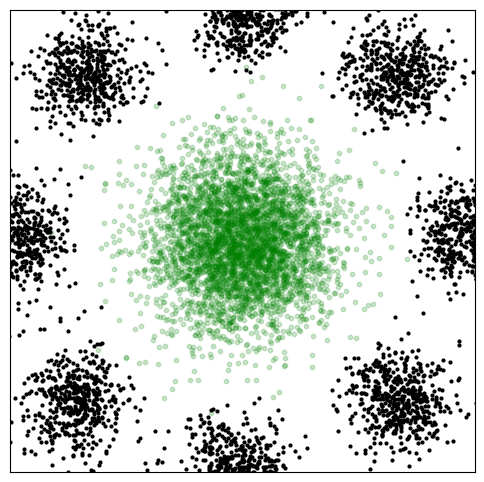

1000: loss 1.207 time 9.56


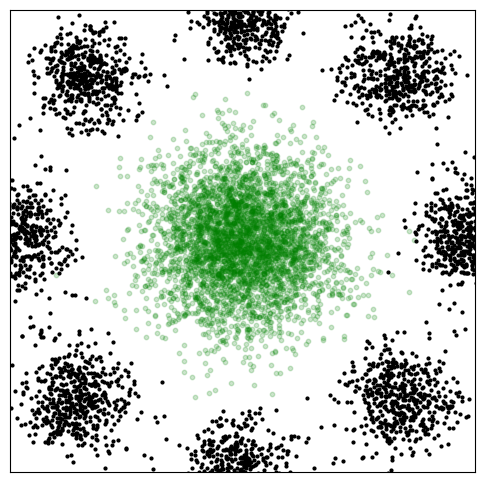

In [8]:
training_enabled = True
pretrained_enable = True
start = time.time()
if training_enabled:
    for k in range(epochs):
        if pretrained_enable:
            model = (torch.load(f"{savedir}/IDFF_model.pt", map_location=torch.device('cpu'))).to(device)
        else:
            pass
        optimizer.zero_grad()

        x1 = sample_8gaussians(batch_size).to(device)
        x0 = torch.randn_like(x1).to(device)
        t, xt, ut, eps = FM.sample_location_and_conditional_flow(x0, x1, return_noise=True)
        lambda_t = FM.compute_lambda(t)
        sigma_t = FM.compute_sigma_t(t)[:, None]

        outs = model(torch.cat([xt, xt, t[:, None]], dim=-1))
        vt = outs[:, :2]
        st = outs[:, 2:]
        flow_loss = torch.mean((vt - FM.x1) ** 2)
        score_loss = torch.mean((lambda_t[:, None] * st + eps) ** 2)
        loss = 2 * flow_loss + score_loss
        loss.backward()

        optimizer.step()

        if (k + 1) % 10000 == 0:
            end = time.time()
            print(f"{k + 1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
            start = end

            sde = SDE(model, model_name="IDFF", sigma=2 * sigma, device=device)
            with torch.no_grad():
                x1 = torch.randn((4098, 2)).to(device)
                traj = torchsde.sdeint(
                    sde,
                    x1,
                    ts=torch.linspace(0, 1, 5, device=device),
                    dt=.2,
                )
                plot_trajectories(traj.cpu().numpy(), x1.cpu().numpy())
                plt.savefig(savedir + f"_generated_IDFF_images_step_{k}.png")
                plt.savefig(savedir + f"_generated_IDFF_images_step_{k}.svg", format='svg')
                plt.show()
            torch.save(model, f"{savedir}/IDFF_model.pt")
else:
    pass


## Test Phase 

### Get sample query

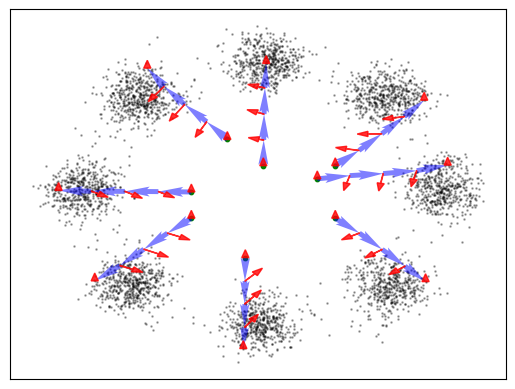

In [9]:
test_enabled = True
NFE = 5
sample_size = 4 * 1024
sde_type = 'IDFF'
if test_enabled:
    model = (torch.load(f"{savedir}/IDFF_model.pt", map_location=torch.device('cpu'))).to(device)
    sde = SDE(model, dt=1/NFE, model_name=sde_type, sigma=1 * sigma, device=device)
    with torch.no_grad():
        # loaded_vector = np.load('random_vector_in_2d.npy')
        x1 = 1 * torch.randn((sample_size, 2)).to(device)
        x_to_show = torch.tensor([
            [0, 1],
            [1.5, .5],
            [-.5, -2.5],
            [-1, 2],
            [2, -1],
            [-2, -1],
            [2, 1],
            [-2, 0],
        ]).to(device)
        x1 = torch.cat([x_to_show, x1], axis=0)
        traj = torchsde.sdeint(
            sde,
            x1,
            ts=torch.linspace(0, 1, NFE, device=device),
            dt=1/NFE,
        )

        ts = torch.linspace(0, 1, 5, device=device)
        moments = []
        for ii, t in enumerate(ts):
            predicts = model(torch.cat([traj[ii], traj[ii], t * torch.ones((traj[ii].shape[0], 1)).to(device)], dim=-1))
            moments.append(-10 * predicts[:, 2:] * torch.sqrt((t) * (1 - t)))

        selected_trs = np.arange(len(x_to_show))

        plt.figure()
        plot_trajectories_m(traj[:, selected_trs, :].cpu().numpy(),
                            x1.cpu().numpy(), torch.stack(moments)[:, selected_trs, :].cpu().numpy(),
                            traj[-1, :, :].cpu().numpy())

        plt.savefig(savedir + f"_generated_IDFF_images_final.png")
        # plt.close()